In [15]:
import pandas as pd
import numpy as np
import math
import os
import sys
import datetime

from scipy.spatial.distance import pdist, squareform
from scipy.fftpack import fft
from sklearn.manifold import MDS
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as dates
plt.style.use('seaborn-whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 4.0) # set default size of plots
import matplotlib.pyplot as plt

C:\Users\adity\AppData\Local\Temp\ipykernel_2844\3796914203.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [16]:

DIR='D:/ME/Lab/Workshop/EDA/Project_EDA_Workshops'
DATA_DIR=DIR+'/Data/'

In [17]:
## Read data
FILE = DATA_DIR + 'timeseriesdata.csv'
df = pd.read_csv(FILE, sep = ",", header = 0)


In [18]:
df['time']

0          1-1-2017 0.00
1          1-1-2017 0.05
2          1-1-2017 0.10
3          1-1-2017 0.15
4          1-1-2017 0.20
               ...      
377714    8-7-2020 11.55
377715    8-7-2020 12.00
377716    8-7-2020 12.05
377717    8-7-2020 12.10
377718    8-7-2020 12.15
Name: time, Length: 377719, dtype: object

In [28]:
df['time'] = pd.to_datetime(df['time'], format='%m-%d-%Y %H.%M')
df.loc[:, (df.columns != 'time')] = df.loc[:, df.columns != 'time'].apply(pd.to_numeric, errors = 'coerce')
df = df.set_index('time')
df.head()

,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
time,,,,,,
2017-01-01 00:00:00,867.63,910.42,-189.54,-186.04,852.13,-145.90
2017-01-01 00:05:00,879.23,918.14,-184.33,-182.10,862.53,-149.76
2017-01-01 00:10:00,875.67,924.18,-181.26,-166.47,866.06,-145.01
2017-01-01 00:15:00,875.28,923.15,-179.15,-174.83,865.85,-142.82
2017-01-01 00:20:00,891.66,934.26,-178.32,-173.72,876.06,-143.39


Text(0, 0.5, '% Missing Values')

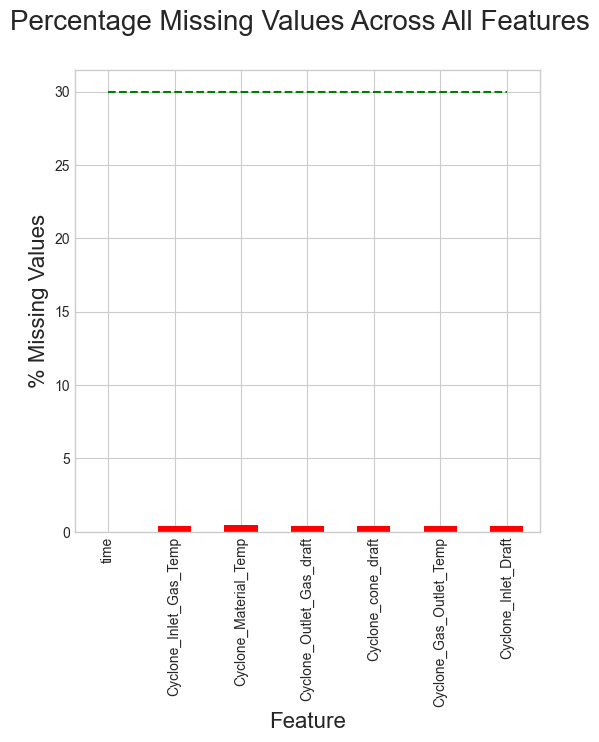

In [20]:
## Plot percentage of missing values (NaNs) for each feature
cutoff = 30
fig = plt.figure(figsize=(6, 6))
percent_missing = (df.isna().sum() / df.shape[0]) * 100
percent_missing.plot(kind = 'bar', color = cm.rainbow(np.linspace(0, 1, 2))[(percent_missing <= cutoff).values.astype(int)])
plt.plot(np.arange(df.shape[1]), np.repeat(cutoff, df.shape[1]), 'g--')
fig.suptitle('Percentage Missing Values Across All Features', fontsize = 20)
plt.xlabel('Feature', fontsize = 16)
plt.ylabel('% Missing Values', fontsize = 16)

In [21]:
print(df.columns!='time')

[False  True  True  True  True  True  True]


In [22]:
df.loc[:,(df.columns!='time')]

,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
0,867.63,910.42,-189.54,-186.04,852.13,-145.90
1,879.23,918.14,-184.33,-182.10,862.53,-149.76
2,875.67,924.18,-181.26,-166.47,866.06,-145.01
3,875.28,923.15,-179.15,-174.83,865.85,-142.82
4,891.66,934.26,-178.32,-173.72,876.06,-143.39
...,...,...,...,...,...,...
377714,899.42,919.79,-224.07,-209.77,901.01,-175.15
377715,879.90,895.02,-228.04,-211.28,878.08,-176.94
377716,887.20,895.70,-230.11,-214.65,885.32,-179.18
377717,908.50,916.33,-231.51,-218.09,906.20,-181.96


In [26]:
type(df.loc[:, df.columns != 'time'])

pandas.core.frame.DataFrame

In [29]:
## Linear interpolation for one column
#df['Cyclone_Inlet_Gas_Temp'] = df['Cyclone_Inlet_Gas_Temp'].interpolate(method = 'linear')
df.loc[:, (df.columns != 'time')] = df.loc[:, df.columns != 'time'].interpolate(method = 'linear')
(df.isna().sum() / df.shape[0]) * 100

Cyclone_Inlet_Gas_Temp      0.0
Cyclone_Material_Temp       0.0
Cyclone_Outlet_Gas_draft    0.0
Cyclone_cone_draft          0.0
Cyclone_Gas_Outlet_Temp     0.0
Cyclone_Inlet_Draft         0.0
dtype: float64

In [30]:
## Data preparation for anomaly detection
feature = df.columns[0] # "Cyclone_Inlet_Gas_Temp"
sampling_period = 5*60 # in seconds of the dataset as provided
time_period =  12*60*60 # time duration in seconds corresoponding to each sample, in this case 12 hours
scaler = {'identity': FunctionTransformer(lambda x: x), 'standard': StandardScaler()}
df_transformed = pd.DataFrame(scaler['identity'].fit_transform(df))
df_transformed.index = df.index.copy()
df_transformed.columns = df.columns.copy()
df_anomaly = df_transformed.groupby(pd.Grouper(freq = str(time_period)+'S')).apply(lambda x: x[feature].values if len(x[feature].values) == int(pd.Timedelta(str(time_period/sampling_period)+'S').total_seconds()) else np.nan)
df_anomaly = df_anomaly.dropna()
df_anomaly.head()

time
2017-01-01 00:00:00    [867.63, 879.23, 875.67, 875.28, 891.66, 878.5...
2017-01-01 12:00:00    [867.67, 894.24, 868.19, 897.61, 858.37, 886.0...
2017-01-02 00:00:00    [874.96, 911.36, 871.52, 902.01, 890.17, 923.8...
2017-01-02 12:00:00    [886.09, 910.84, 876.72, 920.58, 874.44, 909.9...
2017-01-03 00:00:00    [895.79, 890.98, 885.45, 907.22, 880.65, 882.1...
dtype: object

In [ ]:
## Data preparation for autoregression
feature = df.columns[0] # "Cyclone_Inlet_Gas_Temp"
# Sampling period of the dataset (in this case, 5 mins)
sampling_period = int(pd.Timedelta('5min').total_seconds()) # in seconds
# Lag for autoregression (in this case, we regress on the past 12 hours):
lag = int(pd.Timedelta('12h').total_seconds()) # in seconds
scaler = {'identity': FunctionTransformer(lambda x: x), 'standard': StandardScaler()}
df_transformed = pd.DataFrame(scaler['identity'].fit_transform(df))
df_transformed.columns = df.columns.copy()
df_transformed.index = df.index.copy()
# Number of rows for rolling corresponding to the specified lag
nroll = int(pd.Timedelta(str(lag/sampling_period)+'S').total_seconds())+1
# Numpy array for autoregression
X = np.lib.stride_tricks.sliding_window_view(df_transformed[feature], nroll)
print(X)

In [ ]:
## Function for component-plotting a vector (that is, a time series sample)
def plotveccomp(x, xlab, ylab, title, axis = None):
  ax = axis
  component_index = range(0, len(x))
  ax.plot(component_index, x, color = 'black', marker = '')
  ax.plot(component_index, [np.mean(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='blue')
  ax.plot(component_index, [np.mean(x) - np.std(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='red')
  ax.plot(component_index, [np.mean(x) + np.std(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='red')
  ax.xaxis.set_minor_locator(dates.HourLocator(interval=4))
  #ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%M'))  # hours and minutes
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.set_title(title)